# Suomi24 Corpus: Yearly Evolution of Hate and Friendly Speech

This notebook loads message data from PostgreSQL, aggregates yearly counts for hate speech (Query 1), friendly speech (Query 2), and both, and visualizes the results.

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

In [2]:
# Connect to PostgreSQL using SQLAlchemy and load data into pandas DataFrame
db_user = os.environ.get("POSTGRES_USER", "postgres")
db_password = os.environ.get("POSTGRES_PASSWORD", "secret")
db_host = "localhost"
db_port = os.environ.get("POSTGRES_PORT", 5432)
db_name = os.environ.get("POSTGRES_DB", "suomi24")

# Create SQLAlchemy engine
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

query = """
SELECT date, query_type, content FROM messages
WHERE date IS NOT NULL
"""
df = pd.read_sql(query, engine)

df['year'] = pd.to_datetime(df['date']).dt.year

In [3]:
# Aggregate yearly counts for each query type
agg = df.groupby(['year', 'query_type']).size().unstack(fill_value=0)
agg['both'] = agg.get('both', 0)
agg['hate'] = agg.get('hate', 0)
agg['friendly'] = agg.get('friendly', 0)
agg = agg[['hate', 'friendly', 'both']]
agg

query_type,hate,friendly,both
year,,,
2001,5010,5651,195
2002,9062,9975,363
2003,14735,17046,740
2004,26472,30145,1161
2005,39252,46480,1558
2006,50753,60523,2110
2007,45385,56975,1638
2008,46231,54311,1603
2009,49716,49926,1519


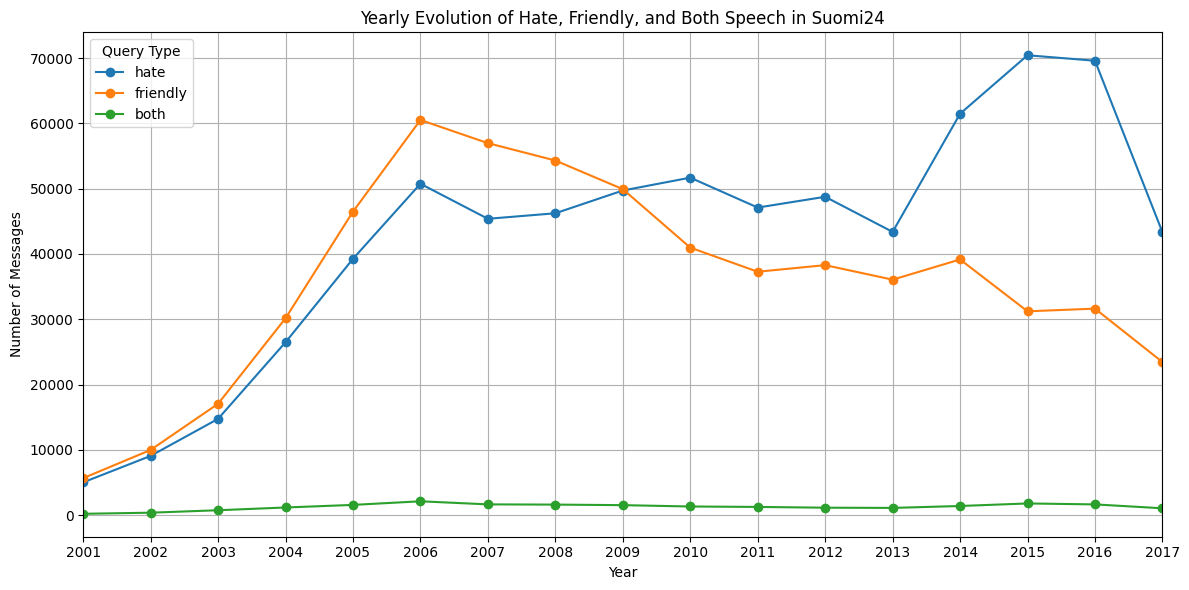

In [4]:
plt.figure(figsize=(12,6))
agg.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Yearly Evolution of Hate, Friendly, and Both Speech in Suomi24')
plt.xlabel('Year')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.legend(title='Query Type')
plt.xlim(2001, 2017)
plt.xticks(range(2001, 2018))
plt.tight_layout()
plt.show()

In [ ]:
def get_avg_tokens_per_message(group):
    token_counts = []
    for content in group['content'].dropna():
        token_counts.append(len(content.split()))
    return sum(token_counts) / len(token_counts) if token_counts else 0

df_filtered = df[df['query_type'].isin(['hate', 'friendly'])]
avg_tokens = df_filtered.groupby(['year', 'query_type']).apply(get_avg_tokens_per_message, include_groups=False).unstack(fill_value=0)
avg_tokens

query_type,friendly,hate
year,,
2001,146.786763,153.383034
2002,181.155088,170.303355
2003,198.224979,183.154462
2004,185.736772,210.998262
2005,170.598171,181.377025
2006,181.068040,191.745434
2007,162.773146,170.740024
2008,158.301928,165.531591
2009,153.063855,139.921675


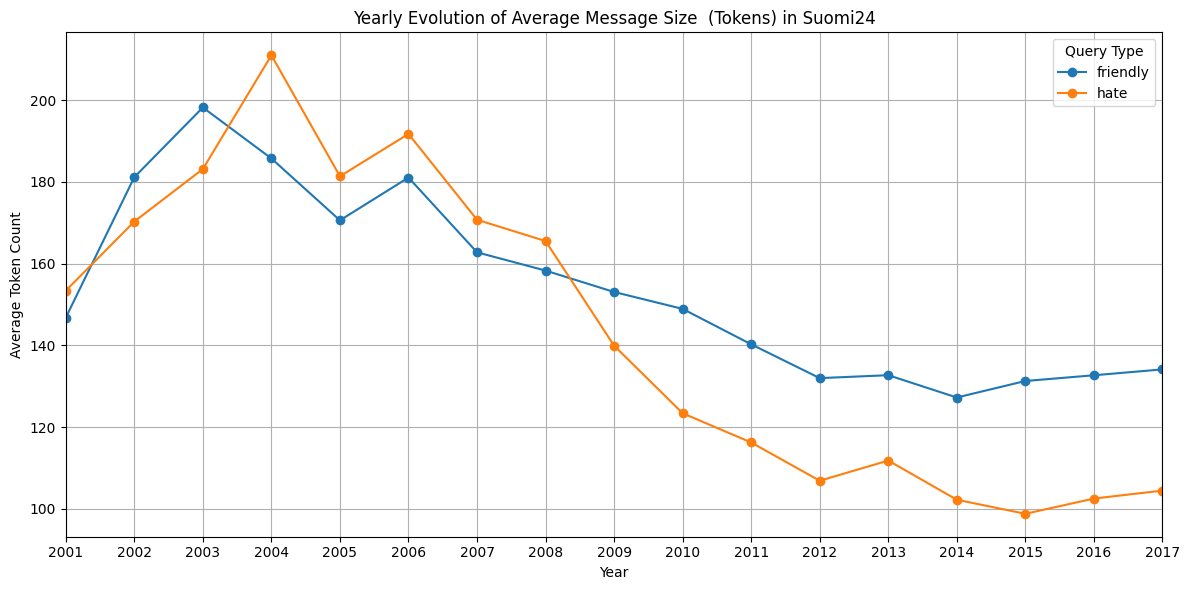

In [6]:
plt.figure(figsize=(12,6))
avg_tokens.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Yearly Evolution of Average Message Size  (Tokens) in Suomi24')
plt.xlabel('Year')
plt.ylabel('Average Token Count')
plt.grid(True)
plt.legend(title='Query Type')
plt.xlim(2001, 2017)
plt.xticks(range(2001, 2018))
plt.tight_layout()
plt.show()

In [11]:
def get_avg_vocab_per_message(group):
    vocab_sizes = []
    for content in group['content'].dropna():
        unique_tokens = set(content.split())
        vocab_sizes.append(len(unique_tokens))
    return sum(vocab_sizes) / len(vocab_sizes) if vocab_sizes else 0

avg_vocab_per_message = df_filtered.groupby(['year', 'query_type']).apply(get_avg_vocab_per_message, include_groups=False).unstack(fill_value=0)

avg_vocab_per_message

query_type,friendly,hate
year,,
2001,99.088303,100.110978
2002,116.769323,109.047451
2003,124.384372,115.819070
2004,118.352695,125.629269
2005,110.076571,111.902909
2006,114.185913,112.300100
2007,106.485687,107.302347
2008,103.798291,103.745712
2009,103.077835,92.737328


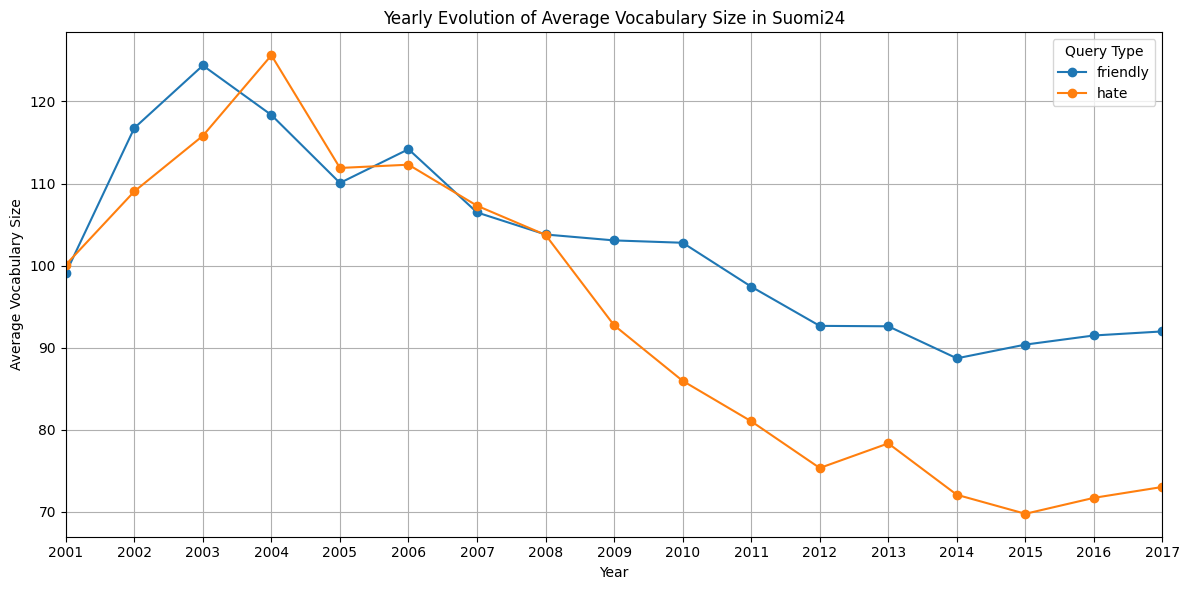

In [12]:
plt.figure(figsize=(12,6))
avg_vocab_per_message.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Yearly Evolution of Average Vocabulary Size in Suomi24')
plt.xlabel('Year')
plt.ylabel('Average Vocabulary Size')
plt.grid(True)
plt.legend(title='Query Type')
plt.xlim(2001, 2017)
plt.xticks(range(2001, 2018))
plt.tight_layout()
plt.show()